Test the rotational dither stacker that is currently in `sims_maf`: a hard cut is implemented s.t. all dithered positions that surpass the min, max rotator angle are set to the min, max.

Running on `minion_1016_sqlite_new_dithers` and `baseline2018a`. Using the `desc-stack` kernel via `JupterLab`.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import lsst.sims.maf.db as db
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.stackers as stackers
import time
import pandas as pd
import os
import numpy as np
import healpy as hp

In [2]:
import lsst.sims.maf
lsst.sims.maf.__version__

'2.9.0.sims'

In [3]:
outDir = '/global/homes/a/awan/LSST/temp_output'
dbfiles = ['/global/cscratch1/sd/awan/dbs_old_unzipped/minion_1016_sqlite_new_dithers.db', 
           '/global/cscratch1/sd/awan/dbs_wp_unzipped/baseline2018a.db']
rot_rand_seed = 42

In [4]:
%%time
data = {}
for dbfile in dbfiles:
    dbkey = dbfile.split('/')[-1]
    print('\n%s'%dbkey)
    opsdb = db.OpsimDatabase(dbfile) # connect to the database

    # set up to run the stackers that add columns for translational and rotational dithers.
    metric = metrics.PassMetric()  # want to access the database; no analysis needed
    slicer = slicers.OneDSlicer(sliceColName='night', binsize=1)   # essentially accessing all nights
    sqlconstraint = None

    resultsDb = db.ResultsDb(outDir=outDir)
    ################################################################################################
    # set up metric bundle to run stackers for the rotational dithers
    stackerList = [stackers.RandomRotDitherPerFilterChangeStacker(degrees=opsdb.raDecInDeg,
                                                                  randomSeed=rot_rand_seed)]

    bundle = metricBundles.MetricBundle(metric, slicer, sqlconstraint=sqlconstraint,
                                        stackerList=stackerList)
    bgroup = metricBundles.MetricBundleGroup({0: bundle}, opsdb, outDir=outDir,
                                             resultsDb=resultsDb, saveEarly=False)
    # run the bundle
    bgroup.runAll()
    
    data[dbkey] = pd.DataFrame(bgroup.simData)
print('')


minion_1016_sqlite_new_dithers.db
Querying database Summary with no constraint for columns ['night', 'filter', 'rotTelPos'].
Found 2447931 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.

baseline2018a.db
Querying database SummaryAllProps with no constraint for columns ['night', 'filter', 'rotTelPos'].
Found 2372700 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.

CPU times: user 29.6 s, sys: 33.3 s, total: 1min 2s
Wall time: 16min 46s


#### Plots to show what the Stacker changes

In [5]:
for key in data:
    data[key]['rot_offset'] = data[key]['randomDitherPerFilterChangeRotTelPos'] - data[key]['rotTelPos']

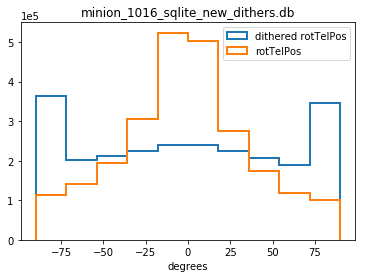

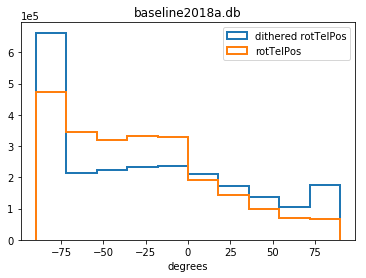

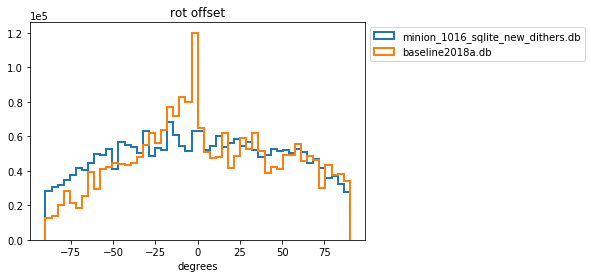

In [6]:
# histograms of rot dithered positions
# convert things to the same units: know that minion1016 has rotTelPos in radians
# while baseline2018a has it in degrees. convert the former to degrees.
for key in data:
    dith, orig = data[key]['randomDitherPerFilterChangeRotTelPos'], data[key]['rotTelPos']
    if key.__contains__('minion'):
        dith, orig = np.degrees(dith), np.degrees(orig)
    
    plt.clf()
    plt.hist(dith, label='dithered rotTelPos', histtype='step', lw=2)
    plt.hist(orig, label='rotTelPos', histtype='step', lw=2)
    plt.legend()
    plt.title(key)
    plt.xlabel('degrees')
    plt.gca().ticklabel_format(style='sci',scilimits=(-3,4),axis='y')
    plt.show()

# plot the offsets
plt.clf()
for key in data:
    off = data[key]['rot_offset']
    if key.__contains__('minion'): off = np.degrees(off)
    plt.hist(off, label=key, histtype='step', lw=2, bins=50)
plt.legend(bbox_to_anchor=(1,1))
plt.title('rot offset')
plt.xlabel('degrees')
plt.gca().ticklabel_format(style='sci',scilimits=(-3,4),axis='y')
plt.show()

A few things to note:
- rotTelPos (undithered) has a markedly different distrbution between minion1016 and baseline2018a.
- dithered rotTelPos has a pile-up at +/-90 -- these show up as misc. offsets since there's a hard cut implemented on the dithered rotTelPos value.

#### Look at some example numbers

In [7]:
for key in data:
    print(key)
    changeIdxs = np.where(data[key]['filter'].values[1:] != data[key]['filter'].values[:-1])[0]
    print(changeIdxs)

minion_1016_sqlite_new_dithers.db
[    228     248     258 ..., 2445720 2445735 2446479]
baseline2018a.db
[    164     184     194 ..., 2372081 2372086 2372698]


In [8]:
data['minion_1016_sqlite_new_dithers.db'][710:730]

,night,filter,rotTelPos,randomDitherPerFilterChangeRotTelPos,rot_offset
710,0,y,-1.525391,-1.570796,-0.045405
711,0,y,-1.522363,-1.570796,-0.048433
712,0,y,-1.519246,-1.570796,-0.051550
713,0,y,-1.516235,-1.570796,-0.054561
714,0,y,-1.513159,-1.570796,-0.057637
715,0,y,-1.509942,-1.570796,-0.060854
716,0,y,-1.506814,-1.570796,-0.063982
717,0,y,-1.503789,-1.570796,-0.067007
718,0,y,-1.500695,-1.570796,-0.070101
719,0,y,-1.497538,-1.570796,-0.073258


Okay, dithered rotTelPos is set to its max limit as we see that visit 710-719 dont see a filter change but the `rot_offset` is different.

In [9]:
data['minion_1016_sqlite_new_dithers.db'][220:270]

,night,filter,rotTelPos,randomDitherPerFilterChangeRotTelPos,rot_offset
220,0,y,0.454702,0.454702,0.000000
221,0,y,0.457668,0.457668,0.000000
222,0,y,0.459975,0.459975,0.000000
223,0,y,0.462174,0.462174,0.000000
224,0,y,0.464474,0.464474,0.000000
225,0,y,0.466708,0.466708,0.000000
226,0,y,0.468890,0.468890,0.000000
227,0,y,0.471182,0.471182,0.000000
228,0,y,0.473379,0.473379,0.000000
229,0,r,0.000000,-0.394144,-0.394144


Good: constant `rot_offset` for visits in between filter changes.

In [10]:
data['baseline2018a.db'][150:200]

,night,filter,rotTelPos,randomDitherPerFilterChangeRotTelPos,rot_offset
150,1,z,-19.865075,-19.865075,0.000000
151,1,z,-20.389867,-20.389867,0.000000
152,1,z,-20.648416,-20.648416,0.000000
153,1,z,-20.954425,-20.954425,0.000000
154,1,z,-21.262854,-21.262854,0.000000
155,1,z,-21.519465,-21.519465,0.000000
156,1,z,-21.758701,-21.758701,0.000000
157,1,z,-21.978204,-21.978204,0.000000
158,1,z,-22.216743,-22.216743,0.000000
159,1,z,-22.477995,-22.477995,0.000000


Good: constant `rot_offset` for visits in between filter changes.